### 一，准备数据


cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。
<img src='./data/cifar2.jpg'>

在tensorflow中准备图片数据的常用方案有两种，第一种是使用tf.keras中的ImageDataGenerator工具构建图片数据生成器。

第二种是使用tf.data.Dataset搭配tf.image中的一些图片处理方法构建数据管道。

第一种方法更为简单，其使用范例可以参考以下文章。

https://zhuanlan.zhihu.com/p/67466552

第二种方法是TensorFlow的原生方法，更加灵活，使用得当的话也可以获得更好的性能。

我们此处介绍第二种方法。

In [1]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*/automobile/.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)


In [2]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

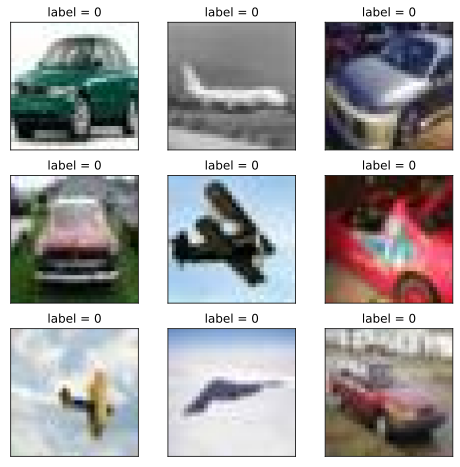

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [4]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


### 二，定义模型


使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建模型。

In [5]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

### 三，训练模型


训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [7]:
import datetime

logdir = "./data/keras_model/20200216-184712"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)


Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 [==============================] - 32s 323ms/step - loss: 0.0082 - accuracy: 0.9998 - val_loss: 8.4068e-13 - val_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 159ms/step - loss: 8.2986e-11 - accuracy: 1.0000 - val_loss: 8.3866e-13 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 158ms/step - loss: 5.3146e-11 - accuracy: 1.0000 - val_loss: 8.3866e-13 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 17s 169ms/step - loss: 7.3521e-11 - accuracy: 1.0000 - val_loss: 8.3865e-13 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 17s 169ms/step - loss: 7.5460e-11 - accuracy: 1.0000 - val_loss: 8.3865e-13 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 17s 169ms/step - loss: 6.0592e-11 - accuracy: 1.0000 - val_loss: 8.3865e-13 - val_accuracy: 1.0000
Epoch 7/10
100/100 [=======================

### 四，评估模型

In [10]:
%load_ext tensorboard
%tensorboard --logdir ./data/keras_model

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 8048.

In [11]:
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6006: logdir ./data/keras_model (started 0:00:56 ago; pid 5668)


In [14]:
#在tensorboard中查看模型
notebook.start("--logdir  ./data/keras_model")

Reusing TensorBoard on port 6006 (pid 5668), started 0:01:56 ago. (Use '!kill 5668' to kill it.)

In [15]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,8.237183e-03,0.9998,8.406804e-13,1.0
2,8.298575e-11,1.0000,8.386609e-13,1.0
3,5.314631e-11,1.0000,8.386579e-13,1.0
4,7.352052e-11,1.0000,8.386546e-13,1.0
5,7.545954e-11,1.0000,8.386495e-13,1.0
6,6.059173e-11,1.0000,8.386470e-13,1.0
7,5.140977e-11,1.0000,8.386437e-13,1.0
8,5.155755e-11,1.0000,8.386412e-13,1.0
9,7.278878e-11,1.0000,8.386298e-13,1.0


In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

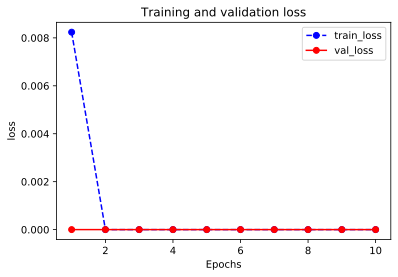

In [17]:
plot_metric(history,"loss")

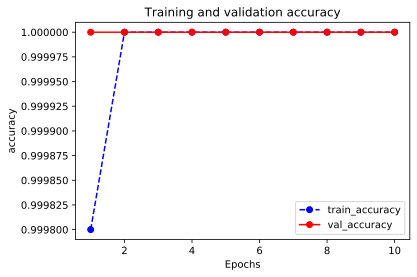

In [18]:
plot_metric(history,"accuracy")

In [19]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)


20/20 [==============================] - 2s 76ms/step - loss: 8.3862e-13 - accuracy: 1.0000
8.386214738612169e-13 1.0


### 五，使用模型


可以使用model.predict(ds_test)进行预测。

也可以使用model.predict_on_batch(x_test)对一个批量进行预测。

In [20]:
model.predict(ds_test)

array([[7.6039506e-29],
       [8.5230845e-19],
       [5.6114435e-22],
       ...,
       [5.8792962e-18],
       [2.2250045e-30],
       [2.4196852e-28]], dtype=float32)

In [21]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

tf.Tensor(
[[1.6316085e-31]
 [2.2745209e-23]
 [1.8804309e-21]
 [3.8200175e-24]
 [2.2962136e-21]
 [2.4196852e-28]
 [9.3136658e-24]
 [4.7866765e-33]
 [1.0418911e-32]
 [0.0000000e+00]
 [9.0340311e-33]
 [1.1247128e-21]
 [4.4292378e-23]
 [1.3330733e-15]
 [1.2874119e-19]
 [2.4981054e-27]
 [1.3811981e-32]
 [7.1919906e-32]
 [2.3132703e-28]
 [3.0644798e-28]], shape=(20, 1), dtype=float32)


### 六，保存模型


推荐使用TensorFlow原生方式保存模型。

In [22]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [23]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel\assets
export saved model.
20/20 [==============================] - 2s 80ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]